## Seminary 1
By Dimitar Djorlev (63220409), Žane Bučan (63220036)

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json

In this seminar we were given a task to create a generic algorithm to develop a smart and efficient system for assigning conference papers to reviewers. The problem was, that some reviewers were friends so they should not review eachothers papers and some had preferences on which paper they want to review. Each paper also had minimum number of reviews that it needs and every reviewer had a maximum number of papers that he can review and of course each author can not review his own paper. We needed to consider these constrains and find the best solution to this problem.

The seminar included four tasks:

### Task 1: Representation
In this task we needed to convert .json files into a representative way, so that the algorithm could understand them. That is why we transformed those files into different matrices.


In [22]:
def load_data(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def parse_json(data):
    N = data["num_papers"]
    K = data["num_reviewers"]
    R = data["reviewer_capacity"]
    min_reviews_per_paper = data["min_reviews_per_paper"]
    max_reviews_per_paper = data["max_reviews_per_paper"]
    
    preference_matrix = np.array(data["preferences"])             ### make all the matrices as ... matrices ofc
    friendship_matrix = np.array(data["friendships"])
    authorship_matrix = np.array(data["authorship"])
    
    return (N, K, R, min_reviews_per_paper, max_reviews_per_paper,
            preference_matrix, friendship_matrix, authorship_matrix)

Next step was to create a fitness fuction, to determine which solution is the best for our problem. It determens the quality of the solutino represented by each individual, giving it a grade (fitnes score), which guides the algorithm to select better solutions for the next generation.

In [23]:
def fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                     capacity, min_reviews_per_paper, max_reviews_per_paper):
    
    fitness = np.sum(assignment * preference_matrix)
    penalty = 0

    # fitness += np.sum(assignment * preference_matrix)
    for j in range(assignment.shape[0]):
        reviews_assigned = assignment[j, :].sum()
        if reviews_assigned > capacity:
            penalty += (reviews_assigned - capacity) * 2

    for i in range(assignment.shape[1]):
        reviews_needed = assignment[:, i].sum()
        if reviews_needed < min_reviews_per_paper:
            penalty += (min_reviews_per_paper - reviews_needed) * 2
        elif reviews_needed > max_reviews_per_paper:
            penalty += (reviews_needed - max_reviews_per_paper) * 2

    for i in range(assignment.shape[0]):
        for j in range(assignment.shape[1]):
            if assignment[i, j] == 1:
                for k in range(authorship_matrix[:, j].shape[0]):
                    if authorship_matrix[k, j] == 1 and friendship_matrix[i, k] == 1:
                        penalty += 5
                # for k in range(j + 1, assignment.shape[1]):
                #     if assignment[i, k] == 1 and friendship_matrix[j, k] == 1:
                #         penalty += 5

    # penalty += np.sum(assignment * friendship_matrix) * 5
    penalty += np.sum(assignment * authorship_matrix) * 6
    return fitness - penalty

The final part of **Task 1** was to create an generic algorithm. Creating one includes more steps.
- Step 1: Create a function that would generate a random assignment. This creates a binary matric (num_papers x num_reviewers) which defines if a reviewer reviews a paper (1) or not (0).

In [24]:
def generate_random_assignment(num_papers, num_reviewers, reviewer_capacity,
                               min_reviews_per_paper, max_reviews_per_paper):
    
    assignment = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for i in range(num_papers):
        reviewers = np.random.choice(range(num_reviewers), 
                                     size=np.random.randint(min_reviews_per_paper, max_reviews_per_paper + 1), 
                                     replace=False)
        assignment[reviewers, i] = 1
    
    for j in range(num_reviewers):
        while assignment[j, :].sum() > reviewer_capacity:
            assigned_papers = np.where(assignment[j, :] == 1)[0]
            paper_to_remove = np.random.choice(assigned_papers)
            assignment[j, paper_to_remove] = 0

    return assignment

- Step 2: Initialize a population of these assignments to test them in our algorithm.

In [25]:
def initialize_population(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    return [generate_random_assignment(N, K, R, min_reviews, max_reviews) for _ in range(pop_size)]

- Step 3: Create functions, which are a crucial to creating a good genercic algorithm.

In [26]:
import random

Mutation: \
Mutation is a function that introduces variability to help the algorithm explore more solutions. It achives that by chainging a random gene (a value in the matric). This helps the algorithm avoid permature convergence on local optima by maintainig exploration capability in the search space.

In [27]:
def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    num_mutates = random.randint(1, 5)
    for n in range(num_mutates):
        i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
        assignment[i, j] = 1 - assignment[i, j]  
    
        if assignment[i, :].sum() > R:
            assignment[i, j] = 0
        if assignment[i, :].sum() < min_reviews:
            assignment[i, j] = 1
        elif assignment[i, :].sum() > max_reviews:
            assignment[i, j] = 0
    return assignment

def mutate_swap(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    k, l = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    
    assignment[i, j], assignment[k, l] = assignment[k, l], assignment[i, j]
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    
    if assignment[k, :].sum() > R:
        assignment[k, l] = 0
    if assignment[k, :].sum() < min_reviews:
        assignment[k, l] = 1
    elif assignment[k, :].sum() > max_reviews:
        assignment[k, l] = 0
    
    return assignment

def mutate_scramble(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    np.random.shuffle(assignment[i, start:end+1])
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def mutate_inversion(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    assignment[i, start:end+1] = assignment[i, start:end+1][::-1]
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

Crossover: \
A crossover function takes two individuals from the population called parents. It takes some part of information from one parent and swaps it with the information of the second parent. With this we achive new individuals called children, who lead the algorithm to explot better traits from multible solutions from the population.

In [28]:
def crossover_one_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    crossover_point = random.randint(0, num_rev - 1)
    child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def crossover_two_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    point1, point2 = sorted(random.sample(range(num_rev), 2))
    child1 = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.vstack((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def crossover_uniform(parent1, parent2):
    num_rev, num_pap = parent1.shape
    child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
    for i in range(num_rev):
        if random.random() > 0.5:
            child1[i, :], child2[i, :] = parent1[i, :], parent2[i, :]
        else:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

Selection: \
Selection is a part of the genetic algorithm, which defines who from the population will be used to create the next generation. It ensures that the better solutions (those with higher fitness) are more likely to be chosen to pass their information to the next generation.

In [29]:
def proportional_selection(population, fitness_scores):
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents

def rank_based_selection(population, fitness_scores):
    ranks = np.argsort(np.argsort(fitness_scores)) + 1
    total_rank = np.sum(ranks)
    
    probabilities = ranks / total_rank
    parents = random.choices(population, weights=probabilities, k=2)
    
    return parents

def tournament_selection(population, fitness_scores, tournament_size=10):
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0], selected[1][0]

Functions which define what type of crossover/mutation/selection we will use:

In [30]:
def select_parents(population, fitness_scores, selection_method='proportional'):
    if selection_method == 'proportional':
        return proportional_selection(population, fitness_scores)
    elif selection_method == 'rank-based':
        return rank_based_selection(population, fitness_scores)
    elif selection_method == 'tournament':
        return tournament_selection(population, fitness_scores)
    else:
        raise ValueError("Invalid selection method")
    
def select_crossover(crossover_method, parent1, parent2):
    if crossover_method == 'one-point':
        return crossover_one_point(parent1, parent2)
    elif crossover_method == 'two-point':
        return crossover_two_point(parent1, parent2)
    elif crossover_method == 'uniform':
        return crossover_uniform(parent1, parent2)
    else:
        raise ValueError("Invalid crossover method")
    
def select_mutation(mutation_method, child, R, min_reviews, max_reviews):
    if mutation_method == 'random':
        return mutate(child, R, min_reviews, max_reviews)
    elif mutation_method == 'swap':
        return mutate_swap(child, R, min_reviews, max_reviews)
    elif mutation_method == 'scramble':
        return mutate_scramble(child, R, min_reviews, max_reviews)
    elif mutation_method == 'inversion':
        return mutate_inversion(child, R, min_reviews, max_reviews)
    else:
        raise ValueError("Invalid mutation method")

And of course the algorithm it self:

In [31]:
def genetic_algorithm(num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix, generations=100, pop_size=20, 
                      parents_mating=2, selection_method='proportional', crossover_method='one-point', mutation_method='scramble'):
    population = initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews)
    best_fitness_scores = []
    
    for generation in range(generations):
        fitness_scores = [fitness_function(ind, preference_matrix, friendship_matrix, authorship_matrix, reviewer_capacity, min_reviews, max_reviews) for ind in population]
        new_population = []
        
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores, selection_method)
            
            child1, child2 = select_crossover(crossover_method, parent1, parent2)
            
            child1 = select_mutation(mutation_method, child1, reviewer_capacity, min_reviews, max_reviews)
            child2 = select_mutation(mutation_method, child2, reviewer_capacity, min_reviews, max_reviews)
            
            new_population.extend([child1, child2])
        
        population = new_population[:pop_size]
        best_fitness = max(fitness_scores)
        best_fitness_scores.append(best_fitness)
        # print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    best_index = np.argmax(fitness_scores)
    return population[best_index], best_fitness_scores, population


These are the results of our algorithm:

The best is:  [[0 1 1 0 0 0 0 0 1 0 0 1 1 0 1]
 [1 0 0 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 1 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 0 0 1 1 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 1 0 0 0 0 1 1 0]
 [0 0 0 1 0 1 0 0 0 1 1 0 0 0 1]
 [0 0 0 0 0 1 1 1 0 0 0 1 0 1 0]]


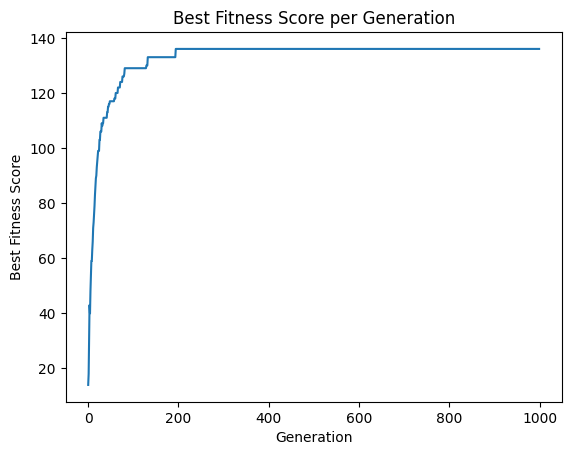

In [32]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

best_assignment, fitness_scores, population = genetic_algorithm(
    num_papers=N, 
    num_reviewers=K, 
    reviewer_capacity=R, 
    min_reviews=min_reviews_per_paper, 
    max_reviews=max_reviews_per_paper, 
    preference_matrix=preference_matrix,
    friendship_matrix=friendship_matrix,
    authorship_matrix=authorship_matrix,
    generations=1000,
    pop_size=50,
    parents_mating = 2,
    selection_method='tournament',
    crossover_method='one-point',
    mutation_method='swap'
)

print("The best is: ", best_assignment)

#### Plot the fitness scores
plt.plot(fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Best Fitness Score per Generation')
plt.show()


##### Test the first functions
# print(parse_json(data))
# assignment = generate_random_assignment(N, K, R, min_reviews_per_paper, max_reviews_per_paper)
# fitness_score = fitness_function(assignment, preference_matrix, friendship_matrix, 
#                                 authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)       
# print(assignment)
# print("Score: ", fitness_score)

### Task 2: Crossover and Mutation
In this task, we needed to upgrade our algorith and our functions to include them in an existing genetic algorithm using PyGad. We still had to be carefull of the constrains each reviewer and paper has, to insure the algorihm creates valid solutions.

In [33]:
import pygad
import time

We redefined the function which inializes the population, so that it would be in a format that is acceptable by pygad

In [34]:
def initialize_population_pygad(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    population = [
        generate_random_assignment(N, K, R, min_reviews, max_reviews).flatten()
        for _ in range(pop_size)
        ]
    return np.array(population)

We combined each function of the algorithm inside a class called GA_utils, to safely store the data which is used in the algorithm.

In [35]:
class GA_utils:
    def __init__(self, preference_matrix, friendship_matrix, authorship_matrix, capacity, min_reviews_per_paper, max_reviews_per_paper):
        self.preference_matrix = preference_matrix
        self.friendship_matrix = friendship_matrix
        self.authorship_matrix = authorship_matrix
        self.capacity = capacity
        self.min_reviews_per_paper = min_reviews_per_paper
        self.max_reviews_per_paper = max_reviews_per_paper
        self.num_genes = preference_matrix.shape[0] * preference_matrix.shape[1]
        self.population = None

    def fitness_function(self, ga_instance, solution, solution_idx):
        assignment = solution.reshape(self.preference_matrix.shape)

        fitness = np.sum(assignment * self.preference_matrix)
        penalty = 0

        for j in range(assignment.shape[0]):
            reviews_assigned = assignment[j, :].sum()
            if reviews_assigned > self.capacity:
                penalty += (reviews_assigned - self.capacity) * 2

        for i in range(assignment.shape[1]):
            reviews_needed = assignment[:, i].sum()
            if reviews_needed < self.min_reviews_per_paper:
                penalty += (self.min_reviews_per_paper - reviews_needed) * 2
            elif reviews_needed > self.max_reviews_per_paper:
                penalty += (reviews_needed - self.max_reviews_per_paper) * 2

        for i in range(assignment.shape[0]):
            for j in range(assignment.shape[1]):
                if assignment[i, j] == 1:
                    for k in range(self.authorship_matrix[:, j].shape[0]):
                        if self.authorship_matrix[k, j] == 1 and self.friendship_matrix[i, k] == 1:
                            penalty += 5

        penalty += np.sum(assignment * self.authorship_matrix) * 6

        return fitness - penalty

    def crossover_one_point(self, parents, offspring_size, ga_instance):
        offspring = []
        crossover_point = np.random.randint(1, parents.shape[1]) 

        for k in range(offspring_size[0]): 
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring.append(child)

        return np.array(offspring)

    def crossover_two_point(self, parents, offspring_size, ga_instance):
        offspring = []
        crossover_point1 = np.random.randint(1, parents.shape[1] - 1)
        crossover_point2 = np.random.randint(crossover_point1 + 1, parents.shape[1])

        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.concatenate((parent1[:crossover_point1], parent2[crossover_point1:crossover_point2], parent1[crossover_point2:]))
            offspring.append(child)

        return np.array(offspring)

    def crossover_uniform(self, parents, offspring_size, ga_instance):
        offspring = []
        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            child = np.zeros(parents.shape[1])
            for gene_idx in range(parents.shape[1]):
                if np.random.rand() < 0.5:
                    child[gene_idx] = parent1[gene_idx]
                else:
                    child[gene_idx] = parent2[gene_idx]
            offspring.append(child)

        return np.array(offspring)
    
    def mutate_flip(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            mutation_indices = np.random.choice(range(offspring.shape[1]), size=int(0.1 * offspring.shape[1]), replace=False)
            for gene_idx in mutation_indices:
                offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
        return offspring

    def mutate_swap(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            swap_indices = np.random.choice(range(offspring.shape[1]), size=2, replace=False)
            offspring[idx, swap_indices[0]], offspring[idx, swap_indices[1]] = offspring[idx, swap_indices[1]], offspring[idx, swap_indices[0]]
        return offspring

    def mutate_inversion(self, offspring, ga_instance):
        for idx in range(offspring.shape[0]):
            start, end = sorted(np.random.choice(range(offspring.shape[1]), size=2, replace=False))
            offspring[idx, start:end] = offspring[idx, start:end][::-1]
        return offspring
    
    def mutate_scramble(self, offspring, ga_instance):
        num_rev, num_pap = offspring.shape
        for id in range(offspring.shape[0]):
            start, end = sorted(np.random.choice(range(num_pap), size=2, replace=False))
            np.random.shuffle(offspring[id, start:end])
        return offspring

    def proportional_selection(self, fitness, num_parents, ga_instance):
        fitness_sum = np.sum(fitness)
        selection_probs = fitness / fitness_sum
        selected_parents = random.choices(population=ga_instance.population, k=2, weights=selection_probs)
        # selected_parents = ga_instance.population[selected_indices]
        #print(selected_parents)
        return selected_parents
    
    def proportional_selection_w_indices(self, fitness, num_parents, ga_instance):
        fitness_sum = np.sum(fitness)
        selection_probs = fitness / fitness_sum
        selected_indices = random.choices(range(len(ga_instance.population)), k=2, weights=selection_probs)
        selected_parents = ga_instance.population[selected_indices]
        #print(selected_parents)
        return selected_parents

    def rank_based_selection(self, fitness, num_parents, ga_instance):
        sorted_indices = np.argsort(fitness)  # Indices sorted by ascending fitness
        ranks = np.argsort(sorted_indices) + 1  # Ranks start from 1
        selection_probs = ranks / np.sum(ranks)
        selected_indices = np.random.choice(range(len(ga_instance.population)), size=num_parents, p=selection_probs)
        selected_parents = ga_instance.population[selected_indices]
        return selected_parents

    def tournament_selection(self, fitness, num_parents, ga_instance, tournament_size=3):
        selected_parents = []
        for _ in range(num_parents):
            # Randomly select participants for the tournament
            tournament_indices = np.random.choice(range(len(ga_instance.population)), size=tournament_size, replace=False)
            # Evaluate fitness of participants
            tournament_fitness = fitness[tournament_indices]
            # Select the winner
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            selected_parents.append(ga_instance.population[winner_idx])
        return np.array(selected_parents)

def delay_on_generation(ga_instance):
    time.sleep(1)

And this are the results of the pygad genetic algorithm.

c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


[0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 0.]
158.0


c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


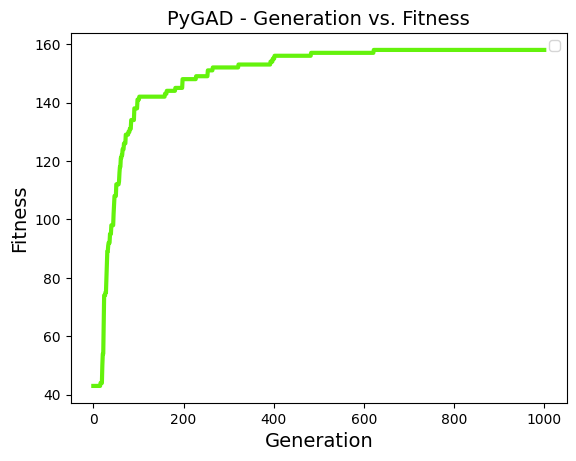

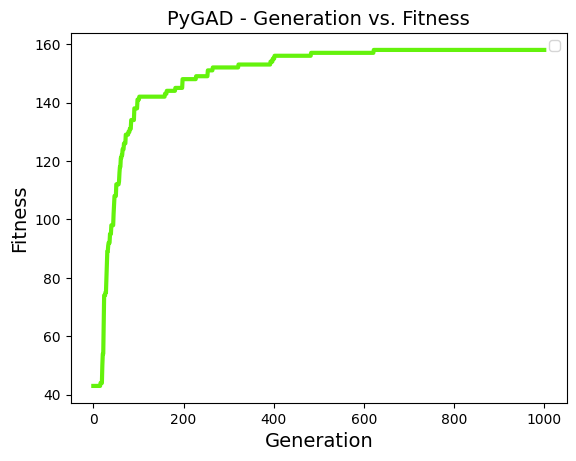

In [36]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

pop_size = 100
initial_pop = initialize_population_pygad(pop_size, N, K, R, min_reviews_per_paper, max_reviews_per_paper)

myEnv = GA_utils(preference_matrix, friendship_matrix, authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)

ga_instance = pygad.GA(
        num_parents_mating=2, 
        num_generations=1000,
        sol_per_pop=20,
        mutation_probability=0.1,
        num_genes=N * K,              
        gene_space=[0, 1],      
        initial_population=initial_pop,
        fitness_func=myEnv.fitness_function,
        # crossover_type="custom",
        crossover_type=myEnv.crossover_one_point,
        # mutation_type="custom",
        mutation_type=myEnv.mutate_swap,
        parent_selection_type="tournament",
        # parent_selection_type=myEnv.proportional_selection_w_indices,
        # on_generation=delay_on_generation
)
ga_instance.run()

solution, fitness, solution_idx = ga_instance.best_solution()

print(solution)
print(fitness)
ga_instance.plot_fitness()

### Task 3: Complexity and Diversity

The aim of this task was to motivate us to create a genetic algotitm to handle complex assignment scenatios by including constrains each reviewer and paper has and encoraging us to create multable genetic operators (mutation, selection, crossover). By penalizing solutions, which do not include these constrais, we ensured balance between efficient solutions while allowing the algorith to explore wide solution space. This will lead to more feasible, efficient and diverse solutions.

### Task 4: Evaluation

In [37]:
import time
dataset_paths = ['datasets/easy_dataset_1.json','datasets/easy_dataset_2.json',
                 'datasets/medium_dataset_1.json','datasets/medium_dataset_2.json',
                 'datasets/hard_dataset_1.json','datasets/hard_dataset_2.json','datasets/hard_dataset_3.json', 'datasets/hard_dataset_4.json']

def load_and_parse_data(file_path):
    data = load_data(file_path)
    return parse_json(data)

results = []

configurations = [
    ('proportional', 'one-point', 'swap'),
    ('rank-based', 'two-point', 'scramble'),
    ('tournament', 'uniform', 'inversion')
]

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
    
    for selection_method, crossover_method, mutation_method in configurations:
        print(f"Evaluating configuration: {selection_method}, {crossover_method}, {mutation_method}")
        
        start_time = time.time()
        best_assignment, fitness_scores, _ = genetic_algorithm(
            num_papers=N, 
            num_reviewers=K, 
            reviewer_capacity=R, 
            min_reviews=min_reviews, 
            max_reviews=max_reviews, 
            preference_matrix=preference_matrix,
            friendship_matrix=friendship_matrix,
            authorship_matrix=authorship_matrix,
            generations=1000,
            pop_size=20,
            parents_mating=2,
            selection_method=selection_method,
            crossover_method=crossover_method,
            mutation_method=mutation_method
        )
        runtime = time.time() - start_time
        best_fitness = max(fitness_scores)
        
        results.append({
            'dataset': dataset_path,
            'selection_method': selection_method,
            'crossover_method': crossover_method,
            'mutation_method': mutation_method,
            'best_fitness': best_fitness,
            'runtime': runtime
        })
results_df = pd.DataFrame(results)

print(results_df)

# 5. Conclusion and Recommendations
# Discuss which configurations performed best and why, as well as potential trade-offs.

# # Save the notebook or export results to a CSV for further analysis
# results_df.to_csv('evaluation_results.csv', index=False)


Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tourn

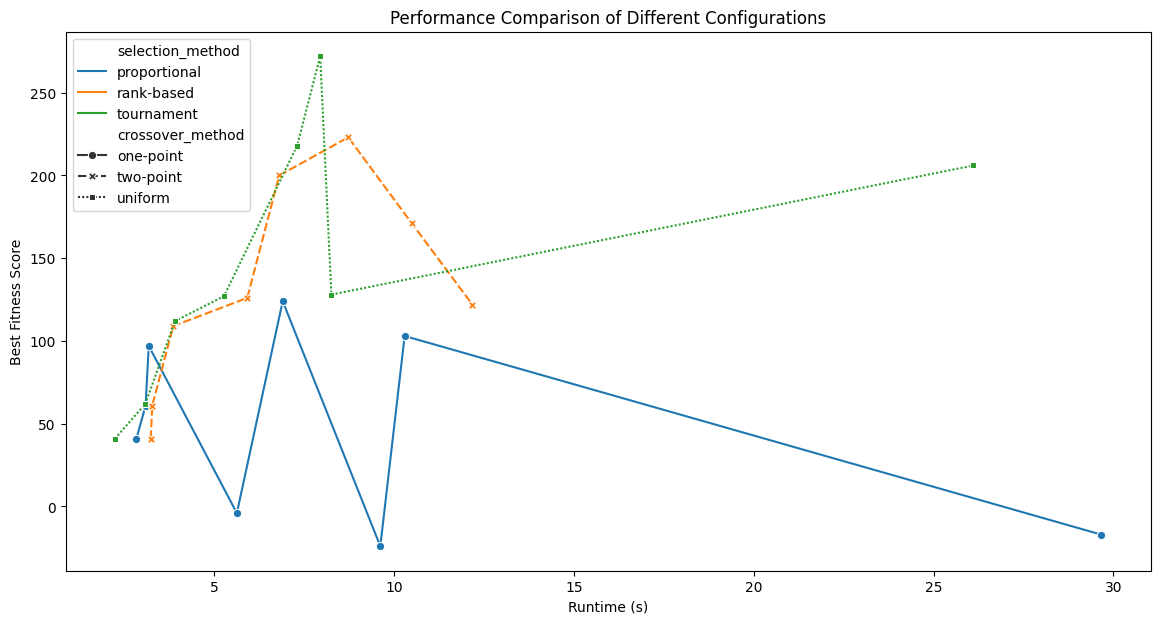

In [38]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='runtime', y='best_fitness', hue='selection_method', style='crossover_method', markers=True)
plt.title('Performance Comparison of Different Configurations')
plt.xlabel('Runtime (s)')
plt.ylabel('Best Fitness Score')
plt.show()

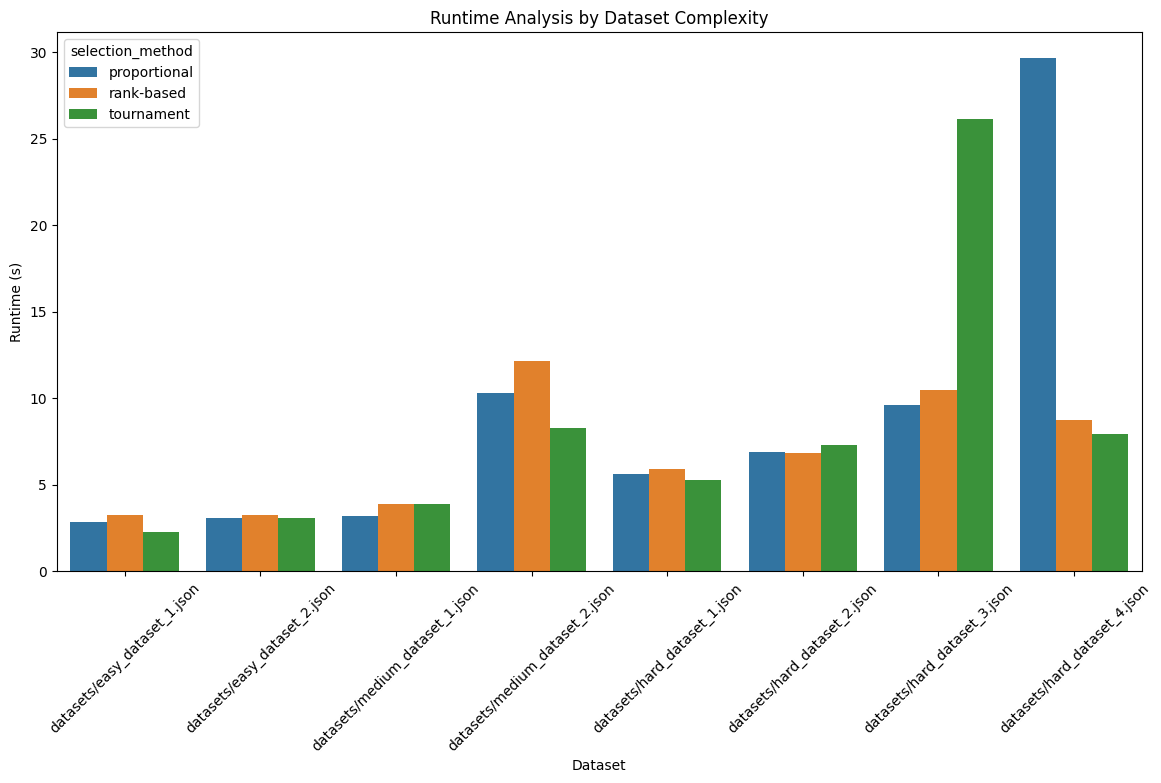

In [46]:
plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='runtime', hue='selection_method', data=results_df)
plt.title('Runtime Analysis by Dataset Complexity')
plt.xlabel('Dataset')
plt.ylabel('Runtime (s)')
plt.xticks(rotation=45)
plt.show()


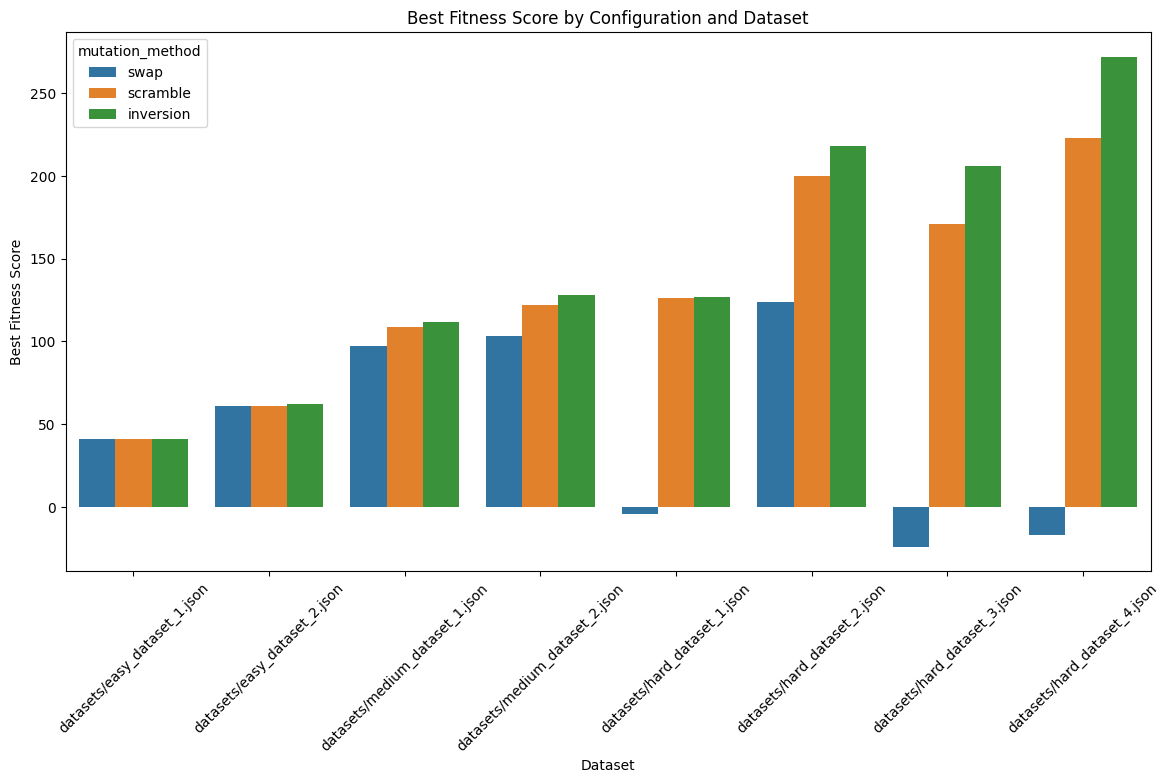

In [47]:

plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='best_fitness', hue='mutation_method', data=results_df)
plt.title('Best Fitness Score by Configuration and Dataset')
plt.xlabel('Dataset')
plt.ylabel('Best Fitness Score')
plt.xticks(rotation=45)
plt.show()


In [44]:
agents = []

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
       
    best_assignment, fitness_scores, population = genetic_algorithm(
        num_papers=N, 
        num_reviewers=K, 
        reviewer_capacity=R, 
        min_reviews=min_reviews, 
        max_reviews=max_reviews, 
        preference_matrix=preference_matrix,
        friendship_matrix=friendship_matrix,
        authorship_matrix=authorship_matrix,
        generations=1000,
        pop_size=20,
        parents_mating=2,
        selection_method='tournament',
        crossover_method='one-point',
        mutation_method='swap'
    )
    best_fitness = max(fitness_scores)
        
    agents.append({
        'dataset': dataset_path,
        'best_fitness': best_fitness,
        'agents': population,
        'fitness': [fitness_function(agent, preference_matrix, friendship_matrix, authorship_matrix, R, min_reviews, max_reviews)
                    for agent in population]
    })
agents_df = pd.DataFrame(agents)

print(agents_df)


                          dataset  best_fitness  \
0    datasets/easy_dataset_1.json            41   
1    datasets/easy_dataset_2.json            64   
2  datasets/medium_dataset_1.json           116   
3  datasets/medium_dataset_2.json           134   
4    datasets/hard_dataset_1.json           138   
5    datasets/hard_dataset_2.json           204   
6    datasets/hard_dataset_3.json           192   
7    datasets/hard_dataset_4.json           280   

                                              agents  \
0  [[[0, 1, 0, 1, 1], [1, 0, 1, 1, 0], [1, 0, 1, ...   
1  [[[0, 1, 0, 0, 1, 1], [1, 0, 0, 1, 0, 1], [0, ...   
2  [[[0, 1, 1, 0, 1, 1, 0, 0, 1, 0], [0, 1, 1, 1,...   
3  [[[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0,...   
4  [[[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1...   
5  [[[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0...   
6  [[[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
7  [[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                   

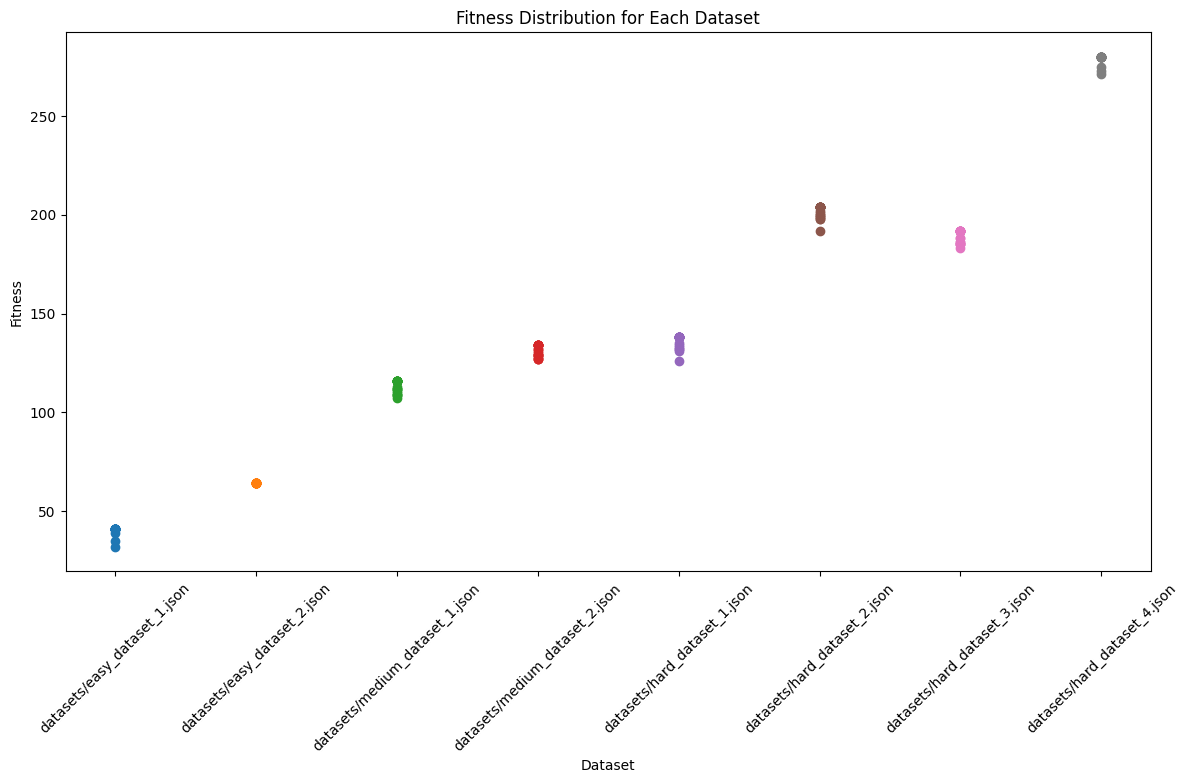

In [48]:
plt.figure(figsize=(14, 7))

for index, row in agents_df.iterrows():
    dataset = row['dataset']
    fitness_values = row['fitness']
    plt.scatter([dataset] * len(fitness_values), fitness_values, label=dataset)

plt.xlabel('Dataset')
plt.ylabel('Fitness')
plt.title('Fitness Distribution for Each Dataset')
plt.xticks(rotation=45)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_22552\4154408296.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Dataset', y='Fitness', data=plot_data, inner='point', palette='muted')


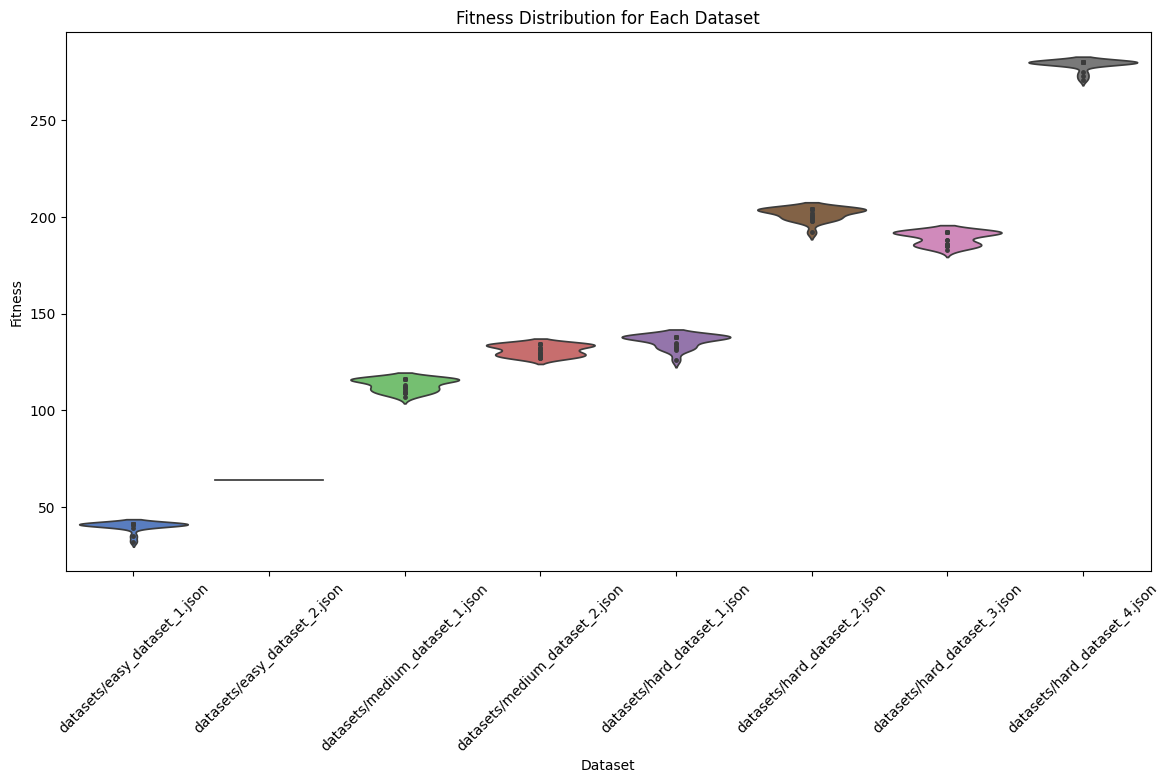

In [ ]:
fitness_values = []
dataset_labels = []

for index, row in agents_df.iterrows():
    dataset = row['dataset']
    fitness_list = row['fitness']
    fitness_values.extend(fitness_list)
    dataset_labels.extend([dataset] * len(fitness_list))

plot_data = pd.DataFrame({
    'Dataset': dataset_labels,
    'Fitness': fitness_values
})

plt.figure(figsize=(14, 7))

sns.violinplot(x='Dataset', y='Fitness', data=plot_data, inner='point', palette='muted')

plt.xlabel('Dataset')
plt.ylabel('Fitness')
plt.title('Fitness Distribution for Each Dataset')
plt.xticks(rotation=45)
plt.show()

In [62]:
configurations = [
    ('tournament', 'one-point', 'random'),
    ('tournament', 'two-point', 'scramble'),
    ('tournament', 'uniform', 'inversion')
]

per_generation_results = []
hardest = 'datasets/hard_dataset_2.json'
N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)

for configuration in configurations:

    selection_method, crossover_method, mutation_method = configuration
    print(f"Evaluating configuration: {selection_method}, {crossover_method}, {mutation_method}")

    _, fitness_scores, _ = genetic_algorithm(
        num_papers=N, 
        num_reviewers=K, 
        reviewer_capacity=R, 
        min_reviews=min_reviews_per_paper, 
        max_reviews=max_reviews_per_paper, 
        preference_matrix=preference_matrix,
        friendship_matrix=friendship_matrix,
        authorship_matrix=authorship_matrix,
        generations=1000,
        pop_size=20,
        parents_mating=2,
        selection_method=selection_method,
        crossover_method=crossover_method,
        mutation_method=mutation_method
    )

    for generation, fitness in enumerate(fitness_scores):
        per_generation_results.append({
            'generation': generation,
            'selection_method': selection_method,
            'crossover_method': crossover_method,
            'mutation_method': mutation_method,
            'fitness': fitness
        })

per_generation_results_df = pd.DataFrame(per_generation_results)
print(per_generation_results_df)

Evaluating configuration: tournament, one-point, random
Evaluating configuration: tournament, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
      generation selection_method crossover_method mutation_method  fitness
0              0       tournament        one-point          random      -50
1              1       tournament        one-point          random      -30
2              2       tournament        one-point          random      -21
3              3       tournament        one-point          random       -8
4              4       tournament        one-point          random       -3
...          ...              ...              ...             ...      ...
2995         995       tournament          uniform       inversion      272
2996         996       tournament          uniform       inversion      272
2997         997       tournament          uniform       inversion      272
2998         998       tournament          uniform       inversion   

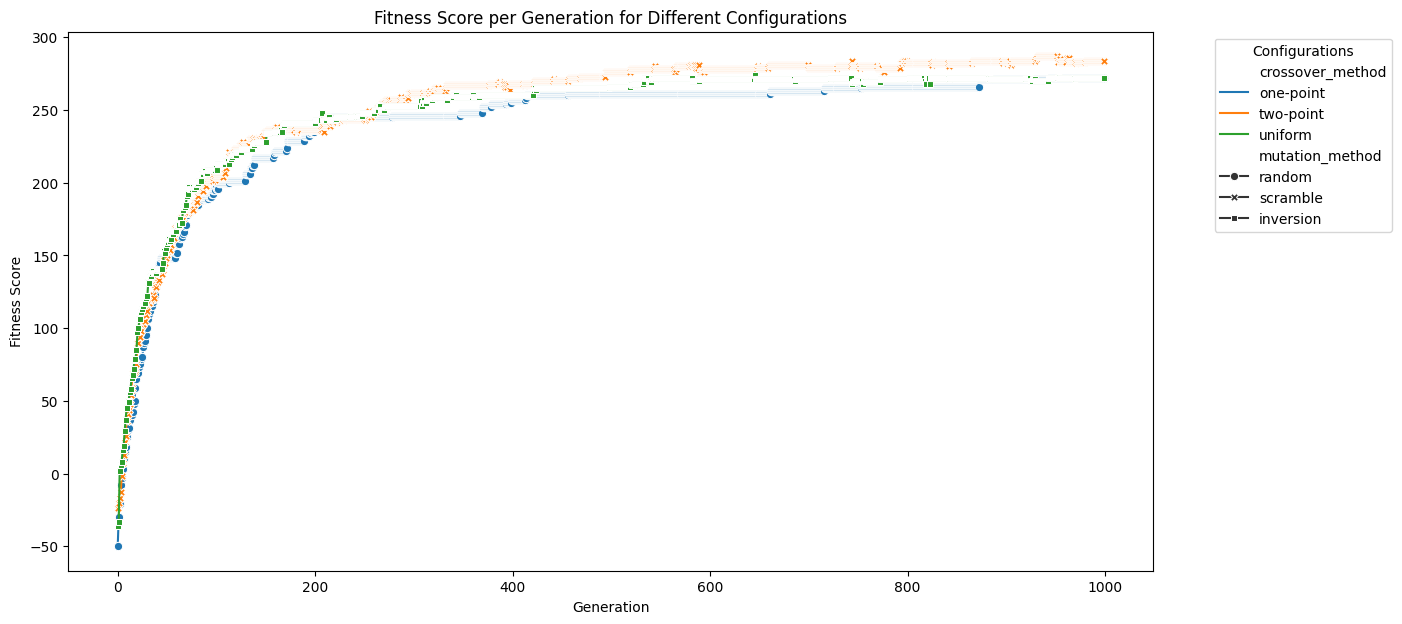

In [63]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=per_generation_results_df, x='generation', y='fitness', hue='crossover_method', style='mutation_method', markers=True, dashes=False)
plt.title('Fitness Score per Generation for Different Configurations')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()